### Code to Compare Model to a Benchmark Created Using the Bottom N Percentile of Points

Note: code uses datasets from manning_baselines.ipynb so ensure that is ran first

In [4]:
import pandas as pd
from joblib import load
import xarray as xr
from pathlib import Path
import numpy as np

import sys
sys.path.append('../')
import config

import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'


In [5]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound

print(f"Exploring {compound} at {site_name}.")

threshold = config.confidence_threshold

Exploring hfc-152a at Mace Head, Ireland.


#### Functions

In [6]:
def calc_benchmark(percentile):
    """
    Calculates benchmark flags based on the given percentile.

    Args:
    - percentile (float): The percentile value used to determine the baseline flag.

    Returns:
    - df_benchmark (pandas.DataFrame): A DataFrame containing the benchmark flags.

    Raises:
    - AssertionError: If no data has been marked as baseline.
    """

    # load in data from manning_baselines.ipynb
    data_ds = xr.open_dataset(data_path/'data_ds.nc')

    # Create a dataframe with molefraction and baseline flags
    df_benchmark = pd.DataFrame({"flag": data_ds.baseline.values, "mf": data_ds.mf.values},
                                index=data_ds.time.values)
    
    
    # adding empty column
    df_benchmark["benchmark_flag"] = np.zeros(len(df_benchmark))

    # assigning a value within empty column for baseline flag (baseline if within lowest n% of mole fraction values, per month [n=percentile])
    # loop through each year
    start_year = data_ds.time.dt.year[0].item()
    end_year = data_ds.time.dt.year[-1].item()

    for year in range(start_year, end_year + 1):
        # loop through each month
        for month in range(1, 13):
            key = f"{year}-{month:02d}"
            # skip if month or year not in data
            if key not in df_benchmark.index:
                continue
            else:
                # extract data for year and month
                df_month = df_benchmark.loc[f"{year}-{month}"].dropna()
                # skip month if contains no data
                if len(df_month) == 0:
                    continue

                # calculate the percentile values (within the lowest n% of mole fraction values)
                percentile_values = np.percentile(df_month["mf"], percentile)
                # add baseline flag if mole fraction value is less than calculated percentile
                df_month["benchmark_flag"] = np.where(df_month["mf"] <= percentile_values, 1, 0)
                # update the dataframe with the new values
                df_benchmark.loc[f"{year}-{month}"] = df_month

    # checking that data has been marked baseline
    assert df_benchmark["benchmark_flag"].where(df_benchmark["benchmark_flag"] == 1).count() > 0

    return df_benchmark

In [7]:
def plot_benchmark(df_benchmark, percentile):
    """
    Plots the benchmarked baselines and their standard deviations against the Manning baselines and their standard deviations, highlighting any points outside three standard deviations.
    
    Args:
    - df_benchmark (DataFrame): DataFrame containing the benchmarked and Manning baselines data.
    - percentile (float): The percentile value used to determine the baseline flag.
    
    Returns:
    - None
    """
    
    df_benchmark_baselines = df_benchmark.where(df_benchmark["benchmark_flag"] == 1).dropna()
    df_benchmark_baselines.drop(columns=["flag"], inplace=True)
    df_actual_baselines = df_benchmark.where(df_benchmark["flag"] == 1).dropna()
    df_actual_baselines.drop(columns=["benchmark_flag"], inplace=True)

    # resampling to monthly averages
    df_benchmark_monthly = df_benchmark_baselines.resample('M').mean()
    df_actual_monthly = df_actual_baselines.resample('M').mean()

    # setting index to year and month only
    df_benchmark_monthly.index = df_benchmark_monthly.index.to_period('M')
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')

    # calculating standard deviation
    std_benchmark_monthly = df_benchmark_baselines.groupby(df_benchmark_baselines.index.to_period('M'))["mf"].std().reset_index()
    std_benchmark_monthly.set_index('index', inplace=True)
    std_actual_monthly = df_actual_baselines.groupby(df_actual_baselines.index.to_period('M'))["mf"].std().reset_index()
    std_actual_monthly.set_index('index', inplace=True)


    # plotting
    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    df_actual_monthly["mf"].plot(ax=ax, label="Manning Baselines", color='green', alpha=0.75)
    df_benchmark_monthly["mf"].plot(ax=ax, label=f"Benchmarked Baselines (bottom {percentile} percent)", color='blue')

    # adding standard deviation shading
    upper_actual = df_actual_monthly["mf"] + std_actual_monthly['mf']
    lower_actual = df_actual_monthly["mf"] - std_actual_monthly['mf']
    ax.fill_between(df_actual_monthly.index, lower_actual, upper_actual, color='green', alpha=0.2, label="Baseline Standard Deviation")

    upper_pred = df_benchmark_monthly["mf"] + std_benchmark_monthly['mf']
    lower_pred = df_benchmark_monthly["mf"] - std_benchmark_monthly['mf']
    ax.fill_between(df_benchmark_monthly.index, lower_pred, upper_pred, color='blue', alpha=0.2, label="Benchmarked Baseline Standard Deviation")


    # adding tolerance range based on 3 standard deviations
    upper_range = df_actual_monthly["mf"] + 3*(std_actual_monthly['mf'])
    lower_range = df_actual_monthly["mf"] - 3*(std_actual_monthly['mf'])

    # calculating overall std for arrows
    overall_std = df_actual_monthly["mf"].std()


    # adding labels to points outside tolerance range
    for i in range(len(df_actual_monthly)):
        # if df_benchmark_monthly["mf"].iloc[i].item() >= upper_range.iloc[i]:
        if df_benchmark_monthly.index[i] in upper_range.index and df_benchmark_monthly["mf"].loc[df_benchmark_monthly.index[i]].item() >= upper_range.loc[df_benchmark_monthly.index[i]]:
            arrow_end = df_benchmark_monthly["mf"].iloc[i] + (overall_std*0.5)
            ax.annotate(df_benchmark_monthly.index[i].strftime('%B %Y'), 
                        xy=(df_benchmark_monthly.index[i], df_benchmark_monthly["mf"].iloc[i]), 
                        xytext=(df_benchmark_monthly.index[i], arrow_end), 
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')

        elif df_benchmark_monthly.index[i] in lower_range.index and df_benchmark_monthly["mf"].loc[df_benchmark_monthly.index[i]].item() <= lower_range.loc[df_benchmark_monthly.index[i]]:
            arrow_end = df_benchmark_monthly["mf"].iloc[i] - (overall_std*0.5)
            ax.annotate(df_benchmark_monthly.index[i].strftime('%B %Y'), 
                        xy=(df_benchmark_monthly.index[i], df_benchmark_monthly["mf"].iloc[i]), 
                        xytext=(df_benchmark_monthly.index[i], arrow_end), 
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')

    plt.ylabel("mole fraction in air / ppt")
    plt.title(f"{compound} at {site_name}", fontsize=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

In [8]:
def compare_benchmark_to_model(df_benchmark, percentile):
    """
    Compares the benchmarked baselines to the actual baselines and those predicted by the model.

    Args:
    - df_benchmark (DataFrame): DataFrame containing the benchmarked baselines.
    - percentile (float): The percentile value used to determine the baseline flag.

    Returns:
    - None
    """
        
    # load in data from manning_baselines.ipynb
    data_balanced_ds = xr.open_dataset(data_path/'data_balanced_ds.nc')
    data_balanced_df = pd.read_csv(data_path/'for_model.csv', index_col='time')

    # making predictions based on model
    if "predicted_flag" in data_balanced_df.columns:
        data_balanced_df.drop(columns=["predicted_flag"], inplace=True)
    # Load model
    rf_model = load(data_path/'rf_model.joblib')
    # Predict baseline values
    df_predict = data_balanced_df.copy()
    df_predict.drop(columns=["flag"], inplace=True)
    class_probabilities_predict = rf_model.predict_proba(df_predict.reset_index(drop=True))
    y_pred = (class_probabilities_predict[:,1] >= threshold).astype(int)

    data_balanced_df["predicted_flag"] = y_pred

    df_plot = data_balanced_df.copy()
    df_plot["mf"] = data_balanced_ds.mf.values


    # extracting flags
    df_pred = df_plot.where(df_plot["predicted_flag"] == 1).dropna()
    df_actual = df_plot.where(df_plot["flag"] == 1).dropna()
    df_benchmark = df_benchmark.where(df_benchmark["benchmark_flag"] == 1).dropna()

    df_pred.index = pd.to_datetime(df_pred.index)
    df_actual.index = pd.to_datetime(df_actual.index)
    df_benchmark.index = pd.to_datetime(df_benchmark.index)

    # resampling to monthly averages
    df_pred_monthly = df_pred.resample('M').mean()
    df_actual_monthly = df_actual.resample('M').mean()
    df_benchmark_monthly = df_benchmark.resample('M').mean()
    # setting index to year and month only
    df_pred_monthly.index = df_pred_monthly.index.to_period('M')
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')
    df_benchmark_monthly.index = df_benchmark_monthly.index.to_period('M')

    # calculating standard deviation
    std_pred_monthly = df_pred.groupby(df_pred.index.to_period('M'))["mf"].std().reset_index()
    std_pred_monthly.set_index('time', inplace=True)
    std_actual_monthly = df_actual.groupby(df_actual.index.to_period('M'))["mf"].std().reset_index()
    std_actual_monthly.set_index('time', inplace=True)
    std_benchmark_monthly = df_benchmark.groupby(df_benchmark.index.to_period('M'))["mf"].std().reset_index()
    std_benchmark_monthly.set_index('index', inplace=True)

    # plotting
    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    df_actual_monthly["mf"].plot(ax=ax, label="Manning Baselines", color='green', alpha=0.75)
    df_pred_monthly["mf"].plot(ax=ax, label="Predicted Baselines", color='red')
    df_benchmark_monthly["mf"].plot(ax=ax, label=f"Benchmarked Baselines (bottom {percentile} percent)", color='blue')

    # adding standard deviation shading
    upper_actual = df_actual_monthly["mf"] + std_actual_monthly['mf']
    lower_actual = df_actual_monthly["mf"] - std_actual_monthly['mf']
    ax.fill_between(df_actual_monthly.index, lower_actual, upper_actual, color='green', alpha=0.2, label="Baseline Standard Deviation")

    upper_pred = df_pred_monthly["mf"] + std_pred_monthly['mf']
    lower_pred = df_pred_monthly["mf"] - std_pred_monthly['mf']
    ax.fill_between(df_pred_monthly.index, lower_pred, upper_pred, color='red', alpha=0.2, label="Predicted Baseline Standard Deviation")

    upper_benchmark = df_benchmark_monthly["mf"] + std_benchmark_monthly['mf']
    lower_benchmark = df_benchmark_monthly["mf"] - std_benchmark_monthly['mf']
    ax.fill_between(df_benchmark_monthly.index, lower_benchmark, upper_benchmark, color='blue', alpha=0.2, label="Benchmarked Baseline Standard Deviation")
    
    plt.ylabel("mole fraction in air / ppt")
    plt.title(f"{compound} at {site_name}", fontsize=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

    # calculating some statistics for numerical comparison
    # mean absolute error (MAE)
    mae_model = np.mean(np.abs(df_pred_monthly["mf"] - df_actual_monthly["mf"]))
    mae_benchmark = np.mean(np.abs(df_benchmark_monthly["mf"] - df_actual_monthly["mf"]))
    print(f"MAE for model: {mae_model:.4f}, MAE for benchmark: {mae_benchmark:.4f}")

    # root mean squared error (RMSE)
    rmse_model = np.sqrt(np.mean((df_pred_monthly["mf"] - df_actual_monthly["mf"])**2))
    rmse_benchmark = np.sqrt(np.mean((df_benchmark_monthly["mf"] - df_actual_monthly["mf"])**2))
    print(f"RMSE for model: {rmse_model:.4f}, RMSE for benchmark: {rmse_benchmark:.4f}")

    # mean absolute percentage error (MAPE)
    mape_model = np.mean(np.abs((df_actual_monthly["mf"] - df_pred_monthly["mf"]) / df_actual_monthly["mf"])) * 100
    mape_benchmark = np.mean(np.abs((df_actual_monthly["mf"] - df_benchmark_monthly["mf"]) / df_actual_monthly["mf"])) * 100
    print(f"MAPE for model: {mape_model:.2f}%, MAPE for benchmark: {mape_benchmark:.2f}%")

#### Results

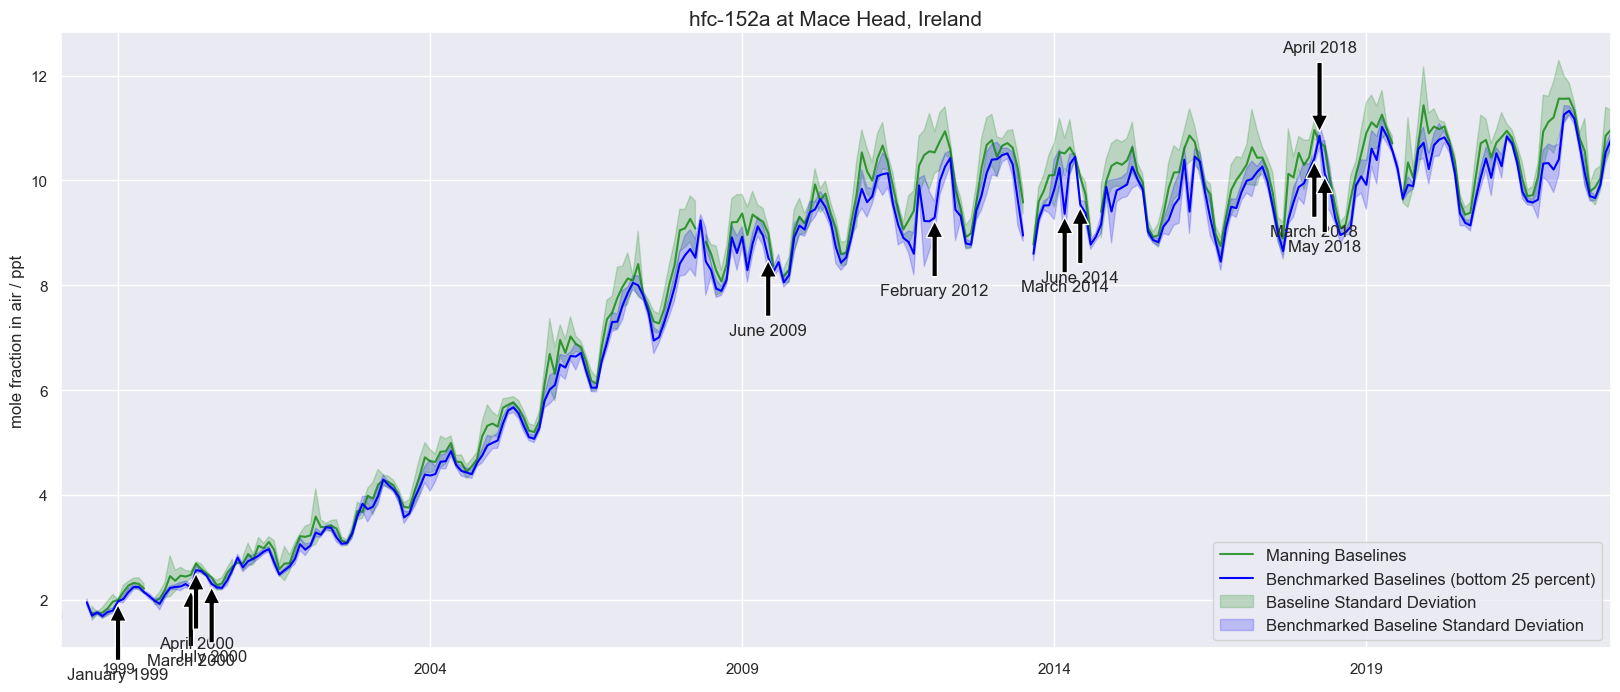

In [16]:
percentile = 25

df_benchmark = calc_benchmark(percentile)
plot_benchmark(df_benchmark, percentile)

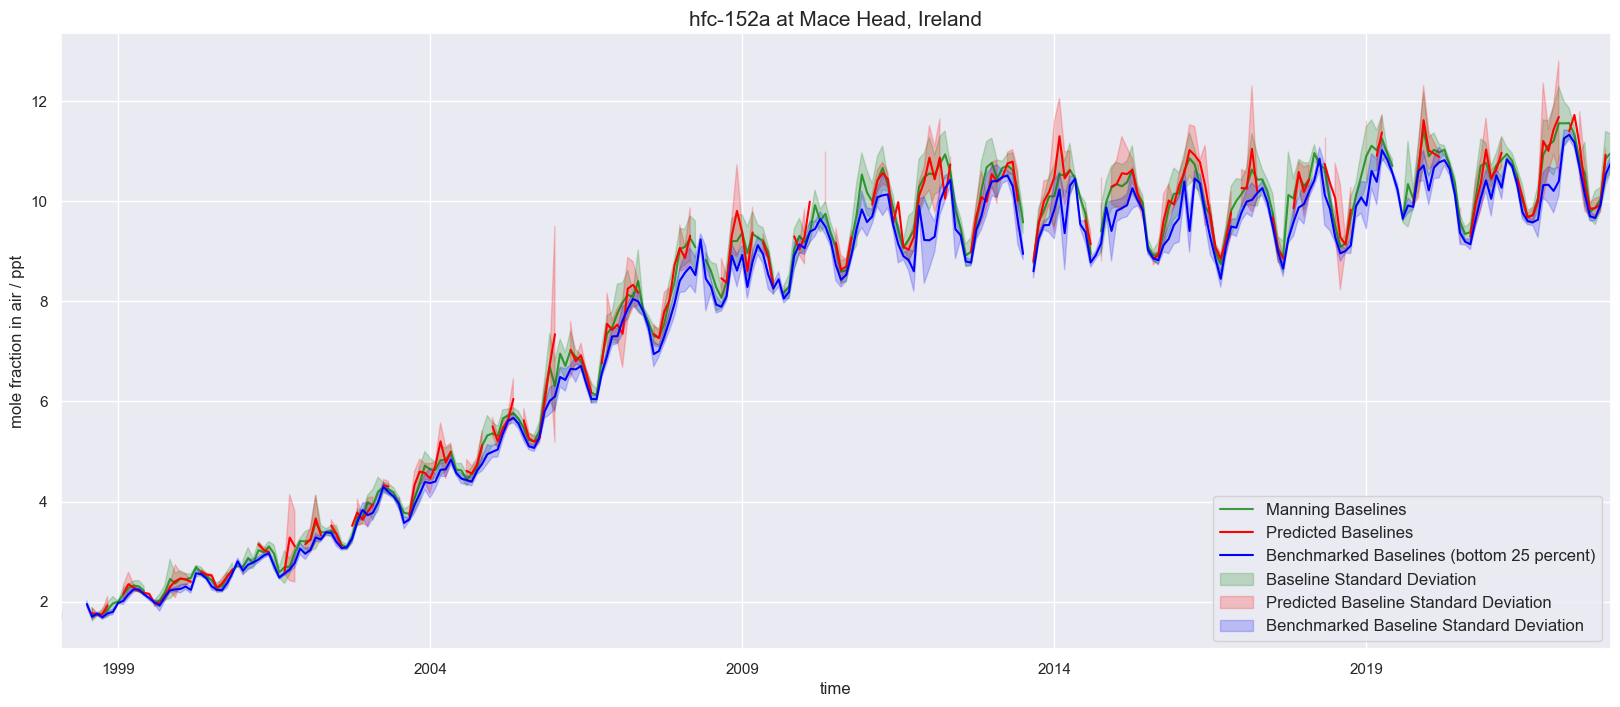

MAE for model: 0.1416, MAE for benchmark: 0.2850
RMSE for model: 0.2148, RMSE for benchmark: 0.3742
MAPE for model: 1.98%, MAPE for benchmark: 3.70%


In [17]:
compare_benchmark_to_model(df_benchmark, percentile)